# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4: West-Nile-Virus-Prediction

## Business problems:

A: predict whether or not West Nile virus is present, for a given time, location, and species, so that the city of Chicago can predict where to spray pesticides!

B: Conduct a cost-benefit analysis. This should include annual cost projections for various levels of pesticide coverage (cost) and the effect of these various levels of pesticide coverage (benefit).

## 0. Import libraries

In [510]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_profiling as pdpro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

## 1. Read in data, EDA, cleaning, Feature Engineering etc.

In [511]:
# Load dataset 
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
sample = pd.read_csv('../assets/sampleSubmission.csv')
weather = pd.read_csv('../assets/weather.csv')

###### a. train and test data cleaning

In [512]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [513]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


Are there some species which tend to be correlated with WNV occurrences?

In [514]:
train.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

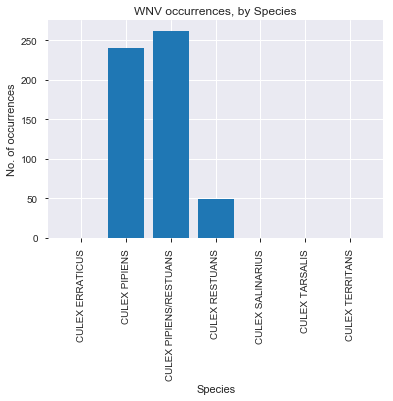

In [515]:
plt.bar(train[['Species','WnvPresent']].groupby('Species').sum().index,
        train[['Species','WnvPresent']].groupby('Species').sum().WnvPresent)
plt.title('WNV occurrences, by Species')
plt.xticks(rotation=90)
plt.xlabel('Species')
plt.ylabel('No. of occurrences');

Clearly, 2 species "CULEX PIPIENS" and "CULEX RESTUANS" are the main causers of WNV. So, Species matters. Let's see if test also has these species.

In [516]:
test.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [517]:
len(test[test.Species=='UNSPECIFIED CULEX'])

14345

Test has 1 unspecified species (viz-a-viz train), and it takes up 14345 rows out of all the 116293 rows in test (~<10%). To err on the side of caution, let's classify all of them as CULEX PIPIENS. Additionally, since "CULEX PIPIENS/RESTUANS" could be either PIPIENS or RESTUANS, lets just let all of them as PIPIENS, to err on the side of caution, since we saw in train that PIPIENS has vastly more WNV cases than RESTUANS. We do the same for train.

In [518]:
test.Species.replace('UNSPECIFIED CULEX', 'CULEX PIPIENS', inplace=True)
test.Species.replace('CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', inplace=True)
train.Species.replace('CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', inplace=True)

Lets first convert to datetime, and create new cols from the date.

In [519]:
train['Date'] = pd.to_datetime(train.Date)
test['Date'] = pd.to_datetime(test.Date)
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
# train['Day'] = train['Date'].dt.day
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
# train['Day'] = train['Date'].dt.day

Are there months in train, that aren't found in test? If so, then we gotta either remove that month in train, or replace it with the next nearest month, so that both train and test have identical features.

In [520]:
print(train.Month.unique())
print(test.Month.unique())

print(len(train[train.Month==5])/len(train[train.Month!=5]))

[ 5  6  7  8  9 10]
[ 6  7  8  9 10]
0.008059873344847437


So train has an extra Month "May". Since it comprises such a small proportion of the overall train dataset (0.8%), lets just remove them. 

In [521]:
train = train[train.Month!=5]
print(train.Month.unique())
print(test.Month.unique())

[ 6  7  8  9 10]
[ 6  7  8  9 10]


Indeed no more data in train, from "May". Let's now see the distribution of WNV occurrences, by year, and by month.

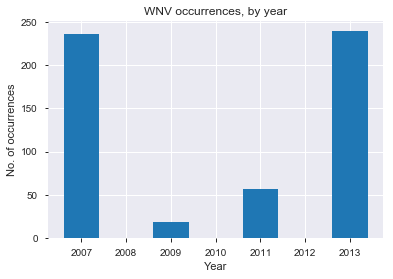

In [522]:
# no. of occurrences, by year
plt.bar(train[['Year','WnvPresent']].groupby('Year').sum().index,
        train[['Year','WnvPresent']].groupby('Year').sum().WnvPresent)
plt.title('WNV occurrences, by year')
plt.xlabel('Year')
plt.ylabel('No. of occurrences');

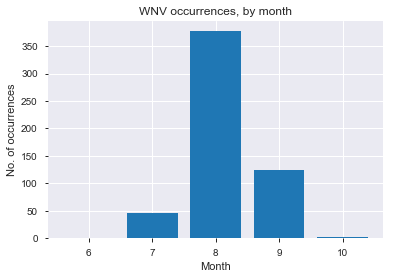

In [523]:
# no. of occurrences, by month
plt.bar(train[['Month','WnvPresent']].groupby('Month').sum().index,
        train[['Month','WnvPresent']].groupby('Month').sum().WnvPresent)
plt.title('WNV occurrences, by month')
plt.xlabel('Month')
plt.ylabel('No. of occurrences');

August, and 2007/2013 had the most occurences of WNV. Clearly, date matters.

Let's see the distribution of WNV occurrences (top 20, bottom 40) - first by Street (more macro view), then by AddressNumberAndStreet (more granular view).

##### Top 20

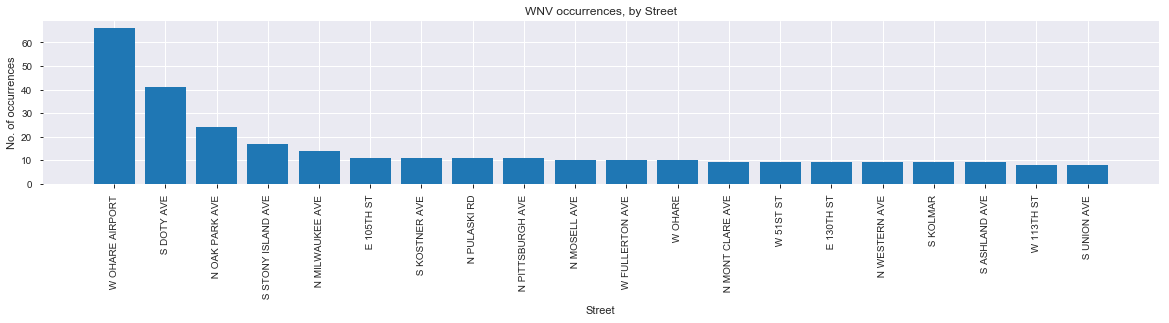

In [524]:
# by Street
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
plt.bar(train[['Street','WnvPresent']].groupby('Street').sum().sort_values('WnvPresent',ascending=False).head(20).index,
        train[['Street','WnvPresent']].groupby('Street').sum().sort_values('WnvPresent',ascending=False).head(20).WnvPresent)
plt.title('WNV occurrences, by Street')
plt.xlabel('Street')
plt.ylabel('No. of occurrences');

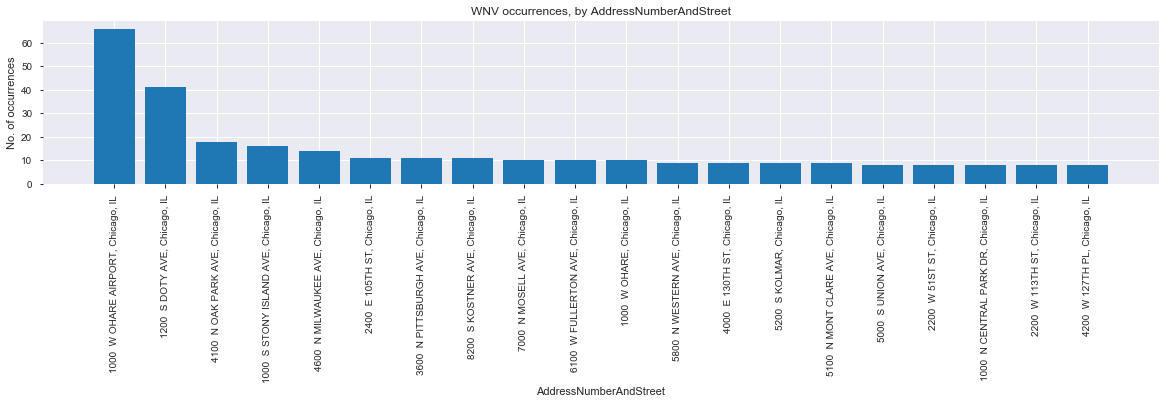

In [525]:
# by AddressNumberAndStreet
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
plt.bar(train[['AddressNumberAndStreet','WnvPresent']].groupby('AddressNumberAndStreet').sum().sort_values('WnvPresent',ascending=False).head(20).index,
        train[['AddressNumberAndStreet','WnvPresent']].groupby('AddressNumberAndStreet').sum().sort_values('WnvPresent',ascending=False).head(20).WnvPresent)
plt.title('WNV occurrences, by AddressNumberAndStreet')
plt.xlabel('AddressNumberAndStreet')
plt.ylabel('No. of occurrences');

We see that top occurrences of WNV happen near OHare Airport, Doty Ave, N Oak Park Ave etc. Clearly, location matters.

##### Bottom 40

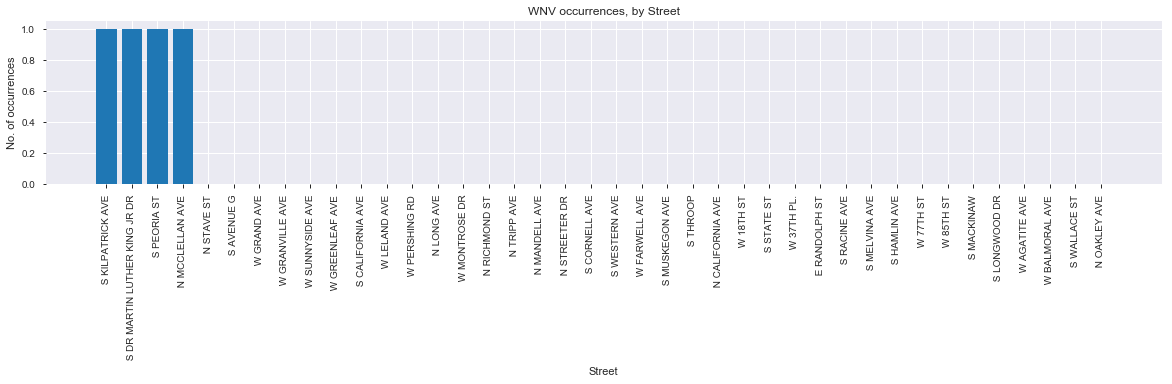

In [526]:
# by Street
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
plt.bar(train[['Street','WnvPresent']].groupby('Street').sum().sort_values('WnvPresent',ascending=False).tail(40).index,
        train[['Street','WnvPresent']].groupby('Street').sum().sort_values('WnvPresent',ascending=False).tail(40).WnvPresent)
plt.title('WNV occurrences, by Street')
plt.xlabel('Street')
plt.ylabel('No. of occurrences');

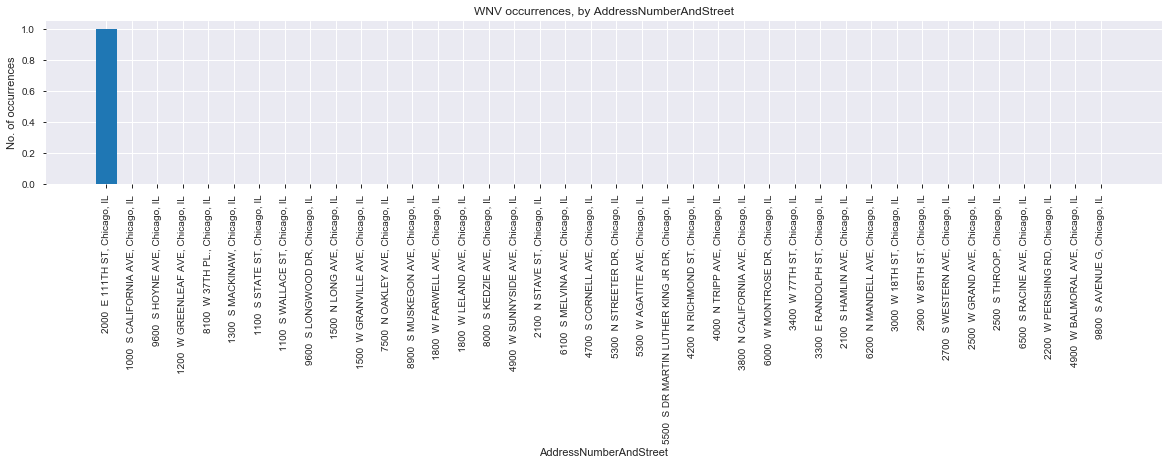

In [527]:
# by AddressNumberAndStreet
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
plt.bar(train[['AddressNumberAndStreet','WnvPresent']].groupby('AddressNumberAndStreet').sum().sort_values('WnvPresent',ascending=False).tail(40).index,
        train[['AddressNumberAndStreet','WnvPresent']].groupby('AddressNumberAndStreet').sum().sort_values('WnvPresent',ascending=False).tail(40).WnvPresent)
plt.title('WNV occurrences, by AddressNumberAndStreet')
plt.xlabel('AddressNumberAndStreet')
plt.ylabel('No. of occurrences');

We see that lowest occurrences of WNV happen near N Stave St, S Avenue G, W Avenue G etc. Clearly, location matters. 

But herein lies the problem: there are some addresses in test, that are not found in train (we check below). We hence cannot use AddressNumberAndStreet (nor its related features eg. Street, Address) as a feature. Because if train lacks those features, then how can we fit on train with limited features, then score on test which has more comprehensive features?

How then? Let's instead use the latitude/longitude - we put them into bins. eg. train df has latitude ranging from 41 to 42, we hence split that into say 10 bins

In [528]:
# check that indeed not all addresses that are found in train, can be found in test
print('No of unique AddressNumberAndStreet in train:',len(train.AddressNumberAndStreet.unique()))
print('No of unique AddressNumberAndStreet in test:',len(test.AddressNumberAndStreet.unique()))

No of unique AddressNumberAndStreet in train: 138
No of unique AddressNumberAndStreet in test: 151


In [529]:
# see min-max range of long/lat for train and test, and put them into COMMON bins (this is IMPORTANT! Cos If both
# train and test don't have common bins, then we won't be able to score on test with the same features from train)
print('train lat range:', train.Latitude.min(),train.Latitude.max())
print('train long range:',train.Longitude.min(),train.Longitude.max())
print('test lat range:', test.Latitude.min(),test.Latitude.max())
print('test long range:',test.Longitude.min(),test.Longitude.max())

train lat range: 41.644612 42.01743
train long range: -87.930995 -87.531635
test lat range: 41.644612 42.01743
test long range: -87.930995 -87.531635


Good! Both train and test, have identical ranges, for their Latitudes and Longitudes (alternatively, if eg. test's lat had a wider range than train's, we would have to first split test's lat into bins, then let train take reference from test. Extra work). We will now split the lat/long into bins, for both train and test.

In [530]:
n_bins = 14   #lets use 14 bins

# train. Create new cols for the binned lat/long
train['Latitude_bin'], lat_bins = pd.cut(train.Latitude, bins=n_bins, retbins=True)
train['Longitude_bin'], long_bins = pd.cut(train.Longitude, bins=n_bins, retbins=True)
# test. Create new cols for the binned lat/long
test['Latitude_bin'] = pd.cut(test.Latitude, bins=n_bins)
test['Longitude_bin'] = pd.cut(test.Longitude, bins=n_bins)

train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Latitude_bin,Longitude_bin
25,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,3,0,2007,6,"(41.938, 41.964]","(-87.817, -87.788]"
26,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,5,0,2007,6,"(41.938, 41.964]","(-87.817, -87.788]"


In [531]:
# # by Longitude_bin
# plt.figure(figsize=(20,3))
# plt.xticks(rotation=45)
# plt.bar(train[['Longitude_bin','WnvPresent']].groupby('Longitude_bin').sum().sort_values('WnvPresent',ascending=False).index.astype('str'),
#         train[['Longitude_bin','WnvPresent']].groupby('Longitude_bin').sum().sort_values('WnvPresent',ascending=False).WnvPresent)
# plt.title('WNV occurrences, by Longitude_bin')
# plt.xlabel('Longitude_bin')
# plt.ylabel('No. of occurrences');

## The highest no. of occurrences of WNV happened within Latitude_bin (41.943, 41.98] and Longitude_bin (-87.811, -87.771], while the lowest no. of occurrences happened within Latitude_bin (41.831, 41.868] and Longitude_bin (-87.931, -87.891].

Where are the "hottest" regions (highest occurrences of WNV)? Or perhaps we can see the distribution of WNV cases over the region?

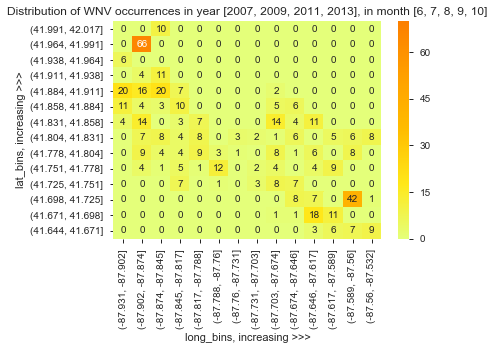

In [635]:
# function to plot heatmap of zones with WNV occurrences

def plot_hotzones(long_bins, lat_bins, df, n_bins, years_array, months_array):
    zone=[] #initialize array to store sum of WNV cases in each lat/long zone
    for j in range(len(long_bins)-1):
        for i in reversed(range(len(lat_bins)-1)): #reverse, cos lat increases from bottom of the map, upwards
            occurrences = df[(pd.cut(df.Latitude, bins=lat_bins) == #within this Latitude_bin
                  df[['Latitude_bin','WnvPresent']].groupby('Latitude_bin').sum().index[i])
                           &
                           (pd.cut(df.Longitude, bins=long_bins) == #within this Longitude_bin
                  df[['Longitude_bin','WnvPresent']].groupby('Longitude_bin').sum().index[j])
                           &
                           (df.WnvPresent==1)
                           &
                           (df.Year.isin(years_array))
                           &
                           (df.Month.isin(months_array))
                               ]
            zone.append(occurrences.AddressNumberAndStreet.value_counts().sum())

    sns.heatmap(np.reshape(zone,(n_bins,n_bins)),xticklabels=df.Longitude_bin.sort_values().unique(),
                yticklabels=df.Latitude_bin.sort_values(ascending=False).unique(),cmap='Wistia', annot=True,
               vmax=70, vmin=0)
    plt.title(f"Distribution of WNV occurrences in year {years_array}, in month {months_array}")
    plt.xlabel('long_bins, increasing >>>');
    plt.ylabel('lat_bins, increasing >>>');
    
#     # get Address of lat/long that have larger than your specified 'no. of WNV occurrences' threshold       
#     indices = [idx for idx, val in enumerate(zone) if val > 10]
#     for index in indices:    
#         lat,long = divmod(index,n_bins)
#         print(index, lat, long)
#         lat = df.Latitude_bin.unique().sort_values()[n_bins-1-lat]
#         long = df.Longitude_bin.unique().sort_values()[long]
#         print(index, lat, long)
#         print(df[(df.Latitude_bin.astype('str')==str(lat)) & (df.Longitude_bin.astype('str')==str(long))].AddressNumberAndStreet.unique())

# plot distribution of WNV cases, for all years in train df, across the entire region
plot_hotzones(long_bins, lat_bins, train, n_bins, years_array=[2007,2009,2011,2013], months_array=[6,7,8,9,10])

Lets verify that the heatmap is correct. Earlier we saw that the AddressNumberAndStreet '1000  W OHARE AIRPORT, Chicago, IL' had the most no. of WNV cases (=66). Here, we check its lat and long, and indeed! It lies within the hottest zone in the heatmap, hence we can confirm that indeed the heatmap has been plotted correctly.

In [471]:
print('No. of WNV cases:',train[(train.AddressNumberAndStreet=='1000  W OHARE AIRPORT, Chicago, IL')].WnvPresent.sum())
print('Lat:',train[(train.AddressNumberAndStreet=='1000  W OHARE AIRPORT, Chicago, IL') & (train.WnvPresent==1)].Latitude.unique())
print('Long:',train[(train.AddressNumberAndStreet=='1000  W OHARE AIRPORT, Chicago, IL') & (train.WnvPresent==1)].Longitude.unique())

No. of WNV cases: 66
Lat: [41.974689]
Long: [-87.890615]


We can see how the no. of occurrences of WNV have varied across different zones, in different years...

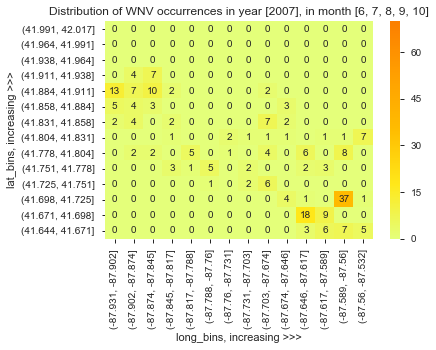

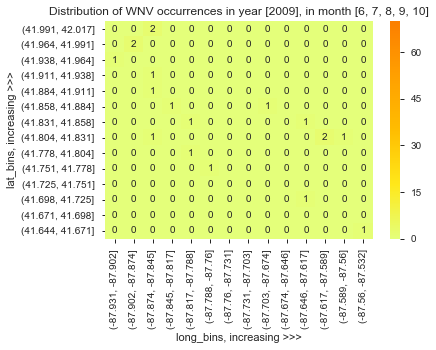

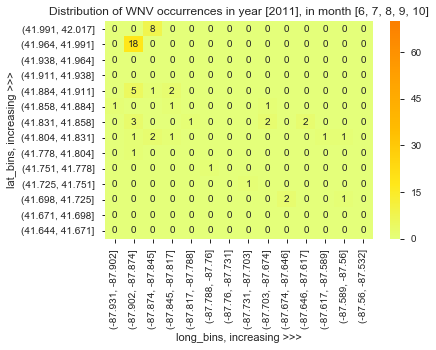

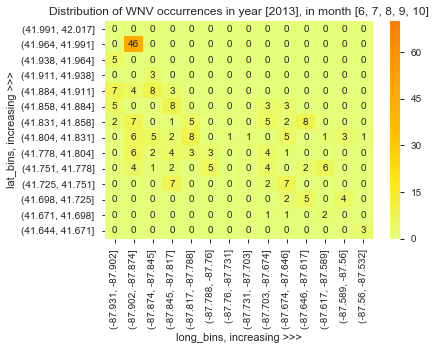

In [537]:
for year in train.Year.unique():
    plot_hotzones(long_bins, lat_bins, train, n_bins, years_array=[year], months_array=[6,7,8,9,10])
    plt.show()

Interesting! We see that the WNV occurrences have migrated from bottom right of the map, to the top left. Let's see at a more granular level - across the months in each year

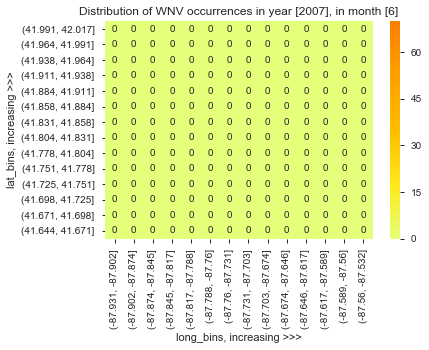

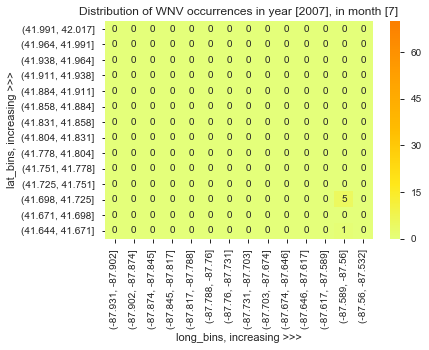

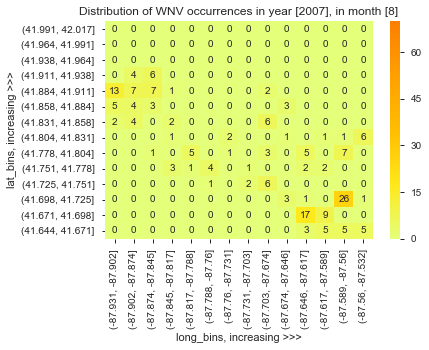

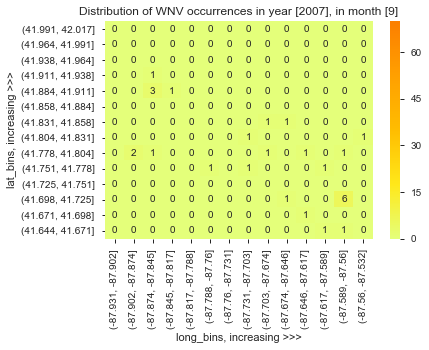

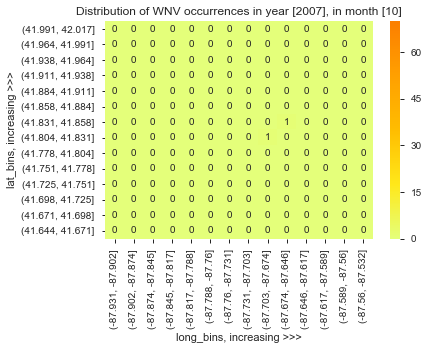

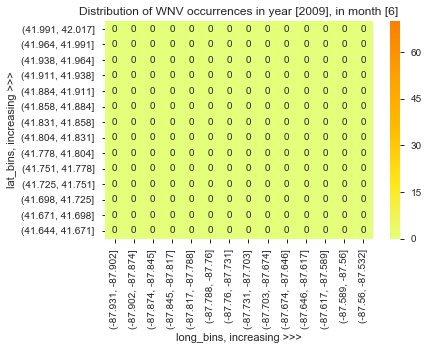

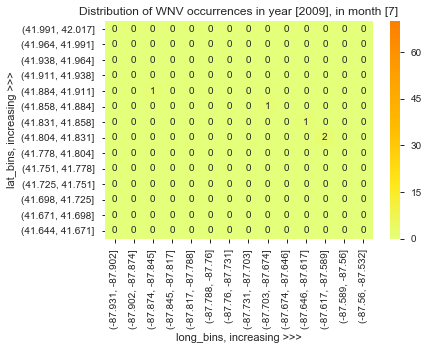

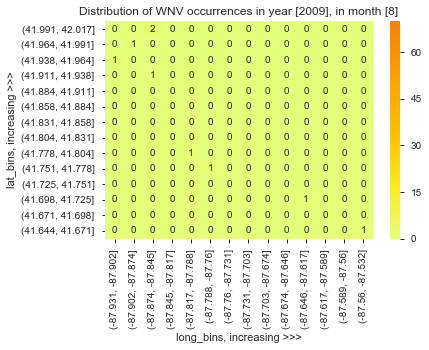

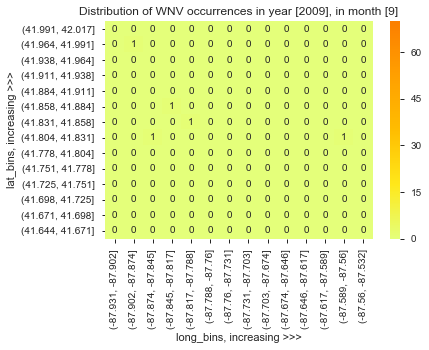

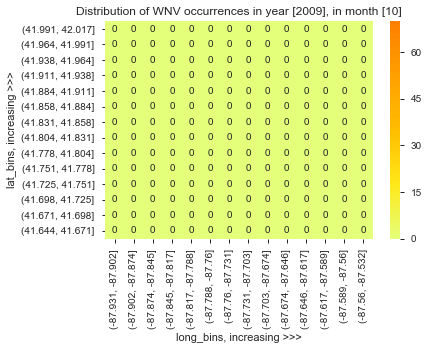

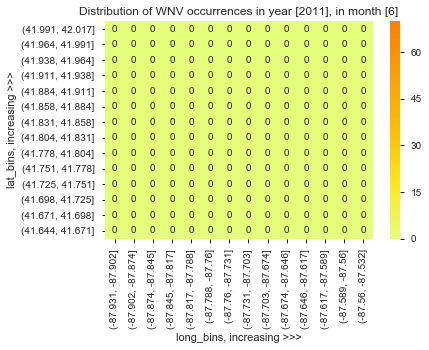

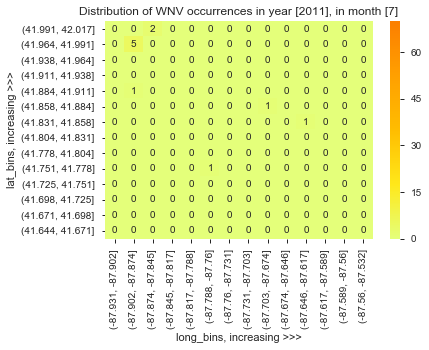

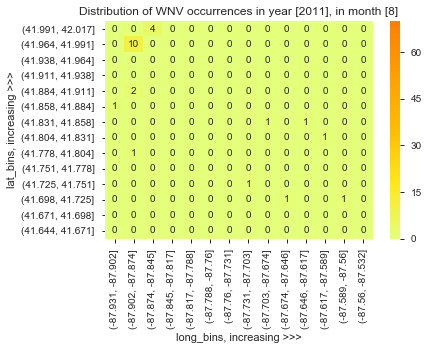

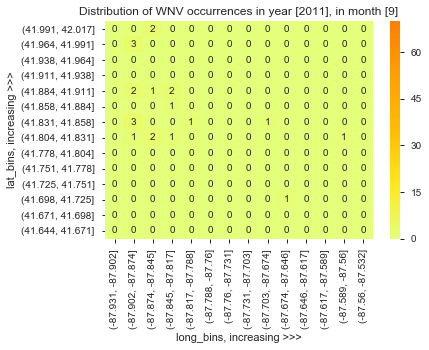

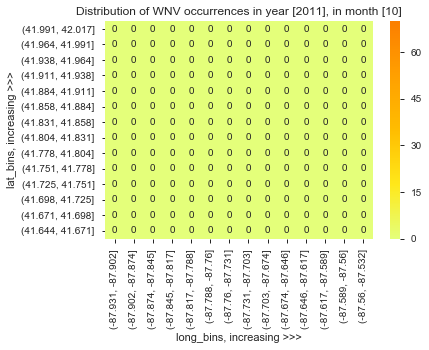

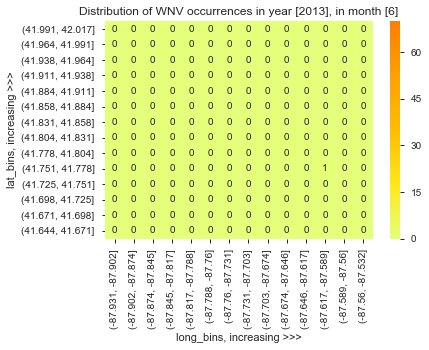

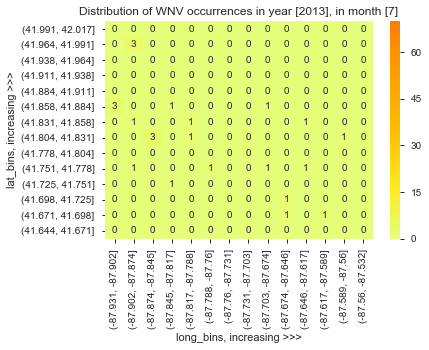

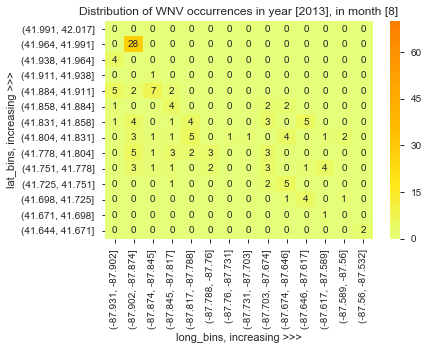

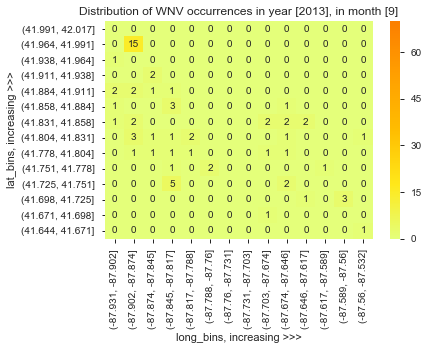

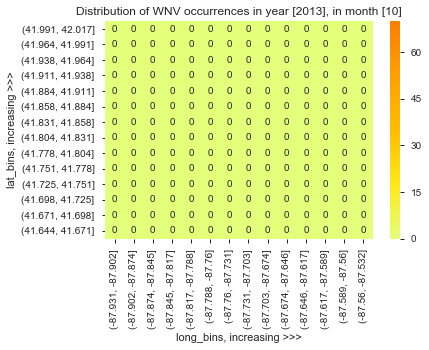

In [538]:
for year in train.Year.unique():
    for month in train.Month.unique():
        plot_hotzones(long_bins, lat_bins, train, n_bins, years_array=[year], months_array=[month])
        plt.show()

Next... are there inbalanced classes?

In [473]:
print(train.WnvPresent.value_counts(normalize=False))
print(train.WnvPresent.value_counts(normalize=True))

0    9871
1     551
Name: WnvPresent, dtype: int64
0    0.947131
1    0.052869
Name: WnvPresent, dtype: float64


Highly inbalanced class distribution, with 95% of 0s. Need to bootstrap the 1s.

In [474]:
train1 = train[train.WnvPresent==1]
train0 = train[train.WnvPresent==0]

# create 9800 samples (with replacement), for train1
train1 = train1.sample(n=9800,replace=True)

train = pd.concat([train1,train0])
print(train.WnvPresent.value_counts())
print(train.WnvPresent.value_counts(normalize=True))

0    9871
1    9800
Name: WnvPresent, dtype: int64
0    0.501805
1    0.498195
Name: WnvPresent, dtype: float64


More balanced! Almost 50/50 now. Baseline score is 0.50

Next, 'Latitude_bin' and 'Longitude_bin' are indicative enough of the location. Hence, we can simply keep these 2 cols to identify the location, and drop all other address related columns, and the Trap column too. We should also drop the col 'NumMosquitos' from train, as test df does not have that feature, so there's no point in retaining it.

In [475]:
train_cleaned = train[['Date','Year','Month','Species','Latitude_bin','Longitude_bin','WnvPresent']]
test_cleaned = test[['Date','Year','Month','Species','Latitude_bin','Longitude_bin']]
train_cleaned.head()

,Date,Year,Month,Species,Latitude_bin,Longitude_bin,WnvPresent
7197,2011-08-05,2011,8,CULEX PIPIENS,"(41.938, 41.964]","(-87.931, -87.902]",1
9898,2013-08-29,2013,8,CULEX PIPIENS,"(41.698, 41.725]","(-87.674, -87.646]",1
10315,2013-09-19,2013,9,CULEX PIPIENS,"(41.938, 41.964]","(-87.845, -87.817]",1
2394,2007-08-22,2007,8,CULEX PIPIENS,"(41.644, 41.671]","(-87.731, -87.703]",1
9879,2013-08-29,2013,8,CULEX PIPIENS,"(41.938, 41.964]","(-87.817, -87.788]",1


In [476]:
test_cleaned.head()

,Date,Year,Month,Species,Latitude_bin,Longitude_bin
0,2008-06-11,2008,6,CULEX PIPIENS,"(41.938, 41.964]","(-87.817, -87.788]"
1,2008-06-11,2008,6,CULEX RESTUANS,"(41.938, 41.964]","(-87.817, -87.788]"
2,2008-06-11,2008,6,CULEX PIPIENS,"(41.938, 41.964]","(-87.817, -87.788]"
3,2008-06-11,2008,6,CULEX SALINARIUS,"(41.938, 41.964]","(-87.817, -87.788]"
4,2008-06-11,2008,6,CULEX TERRITANS,"(41.938, 41.964]","(-87.817, -87.788]"


###### b. weather data cleaning

In [477]:
print(weather.shape)
weather.head()

(2944, 22)


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [478]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


We see here that certain columns should be numerical, yet are categorical. Eg. Tavg, Depart, Wetbulb, Heat, Cool, Sunrise, Sunset, and beyond. Possibly due to some alphabetical values in these columns? Let's explore... 

In [479]:
# first convert col Date to appropriate dtype 
weather['Date'] = pd.to_datetime(weather.Date)

In [480]:
for col in weather.columns:
    print(col,',',np.dtype(weather[col]),':',weather[col].unique())

Station , int64 : [1 2]
Date , datetime64[ns] : ['2007-05-01T00:00:00.000000000' '2007-05-02T00:00:00.000000000'
 '2007-05-03T00:00:00.000000000' ... '2014-10-29T00:00:00.000000000'
 '2014-10-30T00:00:00.000000000' '2014-10-31T00:00:00.000000000']
Tmax , int64 : [ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]
Tmin , int64 : [50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]
Tavg , object : ['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' 

So indeed, many of these columns are (wrongly) of dtype Object, due to the presence of "M" (missing values, according to the pdf documentation), "T/ T/  T" (trace amounts), and "-". Hence lets remove these incorrect values, and then revert the columns to their correct dtypes. Also remove col "Water1" as the entire col is "M" (missing).

In [481]:
features = [col for col in weather.columns if (col!='Date') & (col!='CodeSum')] #these ought to stay as datetime, and object. Leave them be
weather[features] = weather[features].apply(pd.to_numeric, errors = 'coerce') #change other cols to numeric, and convert value to NaN if it's an object
weather.drop(columns=['Water1'], inplace=True)

# lets verify that cols which ought to be numerical, are now numerical
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2933 non-null float64
Depart         1472 non-null float64
DewPoint       2944 non-null int64
WetBulb        2940 non-null float64
Heat           2933 non-null float64
Cool           2933 non-null float64
Sunrise        1472 non-null float64
Sunset         1472 non-null float64
CodeSum        2944 non-null object
Depth          1472 non-null float64
SnowFall       1460 non-null float64
PrecipTotal    2624 non-null float64
StnPressure    2940 non-null float64
SeaLevel       2935 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2941 non-null float64
dtypes: datetime64[ns](1), float64(14), int64(5), object(1)
memory usage: 483.1+ KB


All cols indeed converted to correct numerical dtypes! But still there are a few cols which have substantial nulls, but using dropna would remove a lot of rows and hence lose much useful info, hence let's drop those cols which have many nulls ("Depart", "Sunrise", "Sunset", "Depth", "Snowfall"). We also drop "Tavg" since its derived from "Tmax", "Tmin". We also drop "CodeSum" and choose not to use it

As for the remaining cols which have minimal nulls ("WetBulb", "Heat", "Cool", "PrecipTotal", "StnPressure", "SeaLevel", "AvgSpeed"), we replace nulls with mean values. We cannot simply dropnulls for this latter group of cols, as that would remove some rows from weather, causing the eventual merge with test_cleaned, to yield a df with fewer than Kaggle's required 116293 rows.

In [482]:
weather.drop(columns=['Tavg','Depart','Sunrise','Sunset','CodeSum','Depth','SnowFall'], inplace=True)

In [483]:
for col in weather.columns[5:]: #ignore cols Station/Date/Tmax/Tmin/DewPoint, they have no nulls 
    weather[col].replace(np.NaN, weather[col].mean(), inplace=True)

In [484]:
# and lets check to see if any more nulls remain
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 14 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
DewPoint       2944 non-null int64
WetBulb        2944 non-null float64
Heat           2944 non-null float64
Cool           2944 non-null float64
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null float64
SeaLevel       2944 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 322.1 KB


Good! No more nulls remain, cols with many nulls have been removed, and all values are of the correct types.

In [485]:
# lets take a look at the weather df again
weather.head()

,Station,Date,Tmax,Tmin,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,51,56.0,0.0,2.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,51,57.0,0.0,3.0,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,42,47.0,14.0,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,42,47.0,13.0,0.0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,40,48.0,9.0,0.0,0.0,29.39,30.12,11.7,7,11.9


We know there are 2 weather stations from which data is collected from, daily. Lets now group their data together, by date. If within a day, both stations don't differ too much in their readings (lets check below), could we just take their average? 

In [486]:
# exclude these features in our checks
features = [col for col in weather.columns if (col!='Station') & (col!='Date') & (col!='CodeSum')]

diff=[] #initialise 'difference' array
count=0
for col in weather[features].columns:
    print(col)
    diff.append(weather.groupby('Date')[col].max().values-weather.groupby('Date')[col].min().values)
    print('Mean difference between 2 stations, in a day:',diff[count].mean())
    count+=1

Tmax
Mean difference between 2 stations, in a day: 1.1487771739130435
Tmin
Mean difference between 2 stations, in a day: 2.3519021739130435
DewPoint
Mean difference between 2 stations, in a day: 1.1154891304347827
WetBulb
Mean difference between 2 stations, in a day: 0.7600247707778764
Heat
Mean difference between 2 stations, in a day: 0.548083372863517
Cool
Mean difference between 2 stations, in a day: 0.9505676596154701
PrecipTotal
Mean difference between 2 stations, in a day: 0.10201708311240719
StnPressure
Mean difference between 2 stations, in a day: 0.06058423913043483
SeaLevel
Mean difference between 2 stations, in a day: 0.012336516739500696
ResultSpeed
Mean difference between 2 stations, in a day: 0.8684782608695653
ResultDir
Mean difference between 2 stations, in a day: 2.015625
AvgSpeed
Mean difference between 2 stations, in a day: 0.7717937831704684


Both stations 1 and 2 give largely similar readings (on average, small difference of 0-2.3 units of measurement for every metric, as seen above) for Tmax etc, within a day. Hence, within a day, lets just take the average readings of both stations.

In [487]:
weather12 = weather.copy()                        #make a copy of weather df
weather12 = weather12.groupby('Date').mean()      #group by date, then take the mean of each col
weather12 = weather12.drop(columns=['Station'])   #drop col Station. Wev'e already taken the mean of both stations,
                                                  #hence we dont need this feature anymore
weather12.head()    

,Tmax,Tmin,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,
2007-05-01,83.5,51.0,51.0,56.5,0.000000,2.500000,0.000000,29.140,29.820,2.20,26.0,9.40
2007-05-02,59.5,42.5,42.0,47.0,13.500000,0.000000,0.000000,29.410,30.085,13.15,3.0,13.40
2007-05-03,66.5,47.0,40.0,49.0,8.000000,0.000000,0.000000,29.425,30.120,12.30,6.5,12.55
2007-05-04,72.0,50.0,41.5,50.0,5.203546,2.823559,0.073622,29.335,30.045,10.25,7.5,10.60
2007-05-05,66.0,53.5,38.5,49.5,5.000000,0.000000,0.147245,29.430,30.095,11.45,7.0,11.75


We now have our weather features (all numerical. We've dropped CodeSum from our analysis). Lets merge them with the train and test df, so that we have a train df, and a test df, containing all the relevant weather features to work with.

In [488]:
train_weather = train_cleaned.merge(weather12, on=['Date'])
test_weather = test_cleaned.merge(weather12, on=['Date'])
train_weather.head()

,Date,Year,Month,Species,Latitude_bin,Longitude_bin,WnvPresent,Tmax,Tmin,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2011-08-05,2011,8,CULEX PIPIENS,"(41.938, 41.964]","(-87.931, -87.902]",1,83.5,69.5,68.0,71.0,0.0,11.5,0.147245,29.235,29.92,4.6,6.0,5.75
1,2011-08-05,2011,8,CULEX RESTUANS,"(41.938, 41.964]","(-87.931, -87.902]",1,83.5,69.5,68.0,71.0,0.0,11.5,0.147245,29.235,29.92,4.6,6.0,5.75
2,2011-08-05,2011,8,CULEX PIPIENS,"(41.991, 42.017]","(-87.788, -87.76]",1,83.5,69.5,68.0,71.0,0.0,11.5,0.147245,29.235,29.92,4.6,6.0,5.75
3,2011-08-05,2011,8,CULEX PIPIENS,"(41.938, 41.964]","(-87.931, -87.902]",1,83.5,69.5,68.0,71.0,0.0,11.5,0.147245,29.235,29.92,4.6,6.0,5.75
4,2011-08-05,2011,8,CULEX PIPIENS,"(41.991, 42.017]","(-87.788, -87.76]",1,83.5,69.5,68.0,71.0,0.0,11.5,0.147245,29.235,29.92,4.6,6.0,5.75


Check that test_weather, still has same no. of rows as test (needs to have 116293 rows for Kaggle submission)

In [489]:
print(test.shape)
print(test_weather.shape)

(116293, 15)
(116293, 18)


Good! Same no. of rows in test_weather!

Next, since cols Month, Latitude_bin, Longitude_bin, Species are categorical, lets do get_dummies on them. 

In [490]:
# first lets convert Month to string
# train_weather.Year = train_weather.Year.astype('str')
train_weather.Month = train_weather.Month.astype('str')

# test_weather.Year = test_weather.Year.astype('str')
test_weather.Month = test_weather.Month.astype('str')

# then perform get_dummies
train_weather = pd.get_dummies(train_weather)
test_weather = pd.get_dummies(test_weather)

# verify that cols Latitude_bin and Longitude_bin have indeed been converted to dummy cols. Just check 1st few cols
print(train_weather.columns[:30])
print(test_weather.columns[:30])      

Index(['Date', 'Year', 'WnvPresent', 'Tmax', 'Tmin', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Month_10', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS',
       'Latitude_bin_(41.644, 41.671]', 'Latitude_bin_(41.671, 41.698]',
       'Latitude_bin_(41.698, 41.725]', 'Latitude_bin_(41.725, 41.751]'],
      dtype='object')
Index(['Date', 'Year', 'Tmax', 'Tmin', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Month_10', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS

In [491]:
# check that all cols in train_weather, are also found in test_weather (except for target 'WnvPresent' of course)
for col in train_weather.columns:
    if col not in test_weather.columns:  #print only cols that are found only in train_weather, not test_weather
        print(col)

WnvPresent


Good! Columns Latitude_bin and Longitude_bin have been converted to dummies, and both train_weather and test_weather indeed have the same features (except for "WnvPresent")! We can now proceed to modelling!

## 2. Modelling

### a. Fit and score on train_weather first, just to see how well the model is

In [492]:
features = [col for col in train_weather.columns if (col!='Date') & (col!='WnvPresent')] 

X = train_weather[features]
X.columns = X.columns.str.replace(']',' inclusive') #XGBoost somehow can't have ']' in column names 
y = train_weather.WnvPresent

# train test split on all the Years' data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

Since we are using Classifier Trees (which work well with a mix of categorical and numerical data, which is the case for our data), Standard Scaler is NOT required

##### Random Forest Classifier

In [493]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

rfc.fit(X_train, y_train)
print('Accuracy :',rfc.score(X_test, y_test))
print('ROC score:',roc_auc_score(y_test, rfc.predict(X_test)))

Accuracy : 0.9263024142312579
ROC score: 0.9265165406273396


##### Decision Tree Classifier

In [494]:
dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)
print('Accuracy :',dtc.score(X_test, y_test))
print('ROC score:',roc_auc_score(y_test, dtc.predict(X_test)))

Accuracy : 0.9237611181702668
ROC score: 0.9239752168294921


##### Extra Trees Classifier

In [495]:
etc = ExtraTreesClassifier(random_state=42, n_jobs=-1)

etc.fit(X_train, y_train)
print('Accuracy :',etc.score(X_test, y_test))
print('ROC score:',roc_auc_score(y_test, etc.predict(X_test)))

Accuracy : 0.931130876747141
ROC score: 0.9313207082175368


##### XGBoost

In [496]:
xgbc = xgb.XGBClassifier(random_state=42, n_jobs=-1)

xgbc.fit(X_train, y_train)
print('Accuracy :',xgbc.score(X_test, y_test))
print('ROC score:',roc_auc_score(y_test, xgbc.predict(X_test)))

Accuracy : 0.7944091486658196
ROC score: 0.7946142793593617


For all the above models, their accuracy scores were significantly higher than the baseline score of 0.5, and the ROC AUC scores were also high. But that's not enough, we still need to see how our model performs against Kaggle...

### b. Now lets validate on test_weather (this is more important than the score we got above, as this is what Kaggle will score)

In [497]:
X_kaggle = test_weather[features] #get same features as per X
X_kaggle.columns = X_kaggle.columns.str.replace(']',' inclusive') #XGBoost somehow can't have ']' in column names 

X_kaggle.head(2)

,Year,Tmax,Tmin,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,...,"Longitude_bin_(-87.817, -87.788 inclusive","Longitude_bin_(-87.788, -87.76 inclusive","Longitude_bin_(-87.76, -87.731 inclusive","Longitude_bin_(-87.731, -87.703 inclusive","Longitude_bin_(-87.703, -87.674 inclusive","Longitude_bin_(-87.674, -87.646 inclusive","Longitude_bin_(-87.646, -87.617 inclusive","Longitude_bin_(-87.617, -87.589 inclusive","Longitude_bin_(-87.589, -87.56 inclusive","Longitude_bin_(-87.56, -87.532 inclusive"
0,2008,86.0,63.5,55.5,64.0,0.0,10.0,0.0,29.31,29.98,...,1,0,0,0,0,0,0,0,0,0
1,2008,86.0,63.5,55.5,64.0,0.0,10.0,0.0,29.31,29.98,...,1,0,0,0,0,0,0,0,0,0


Now we make predictions, and check that shape is correct (gotta have 116293 rows!), then save into a csv as per sample.csv.

##### Random Forest Classifier

In [498]:
y_pred = pd.DataFrame(rfc.predict(X_kaggle),columns=['WnvPresent'],index=X_kaggle.index)
y_pred.index += 1       #index to start from 1, as per submssion sample
y_pred.index.name='Id'  #rename index, as per submssion sample
print(y_pred.shape)     #check shape. Gotta have 116293 rows!
y_pred.to_csv('submission.csv')

(116293, 1)


Kaggle score 0.51907. Not terrific

##### Decision Tree Classifier

In [499]:
y_pred = pd.DataFrame(dtc.predict(X_kaggle),columns=['WnvPresent'],index=X_kaggle.index)
y_pred.index += 1       #index to start from 1, as per submssion sample
y_pred.index.name='Id'  #rename index, as per submssion sample
print(y_pred.shape)     #check shape. Gotta have 116293 rows!
y_pred.to_csv('submission.csv')

(116293, 1)


Kaggle score 0.57469

##### Extra Trees Classifier

In [500]:
y_pred = pd.DataFrame(etc.predict(X_kaggle),columns=['WnvPresent'],index=X_kaggle.index)
y_pred.index += 1       #index to start from 1, as per submssion sample
y_pred.index.name='Id'  #rename index, as per submssion sample
print(y_pred.shape)     #check shape. Gotta have 116293 rows!
y_pred.to_csv('submission.csv')

(116293, 1)


Kaggle score 0.56073

##### XGBoost

In [501]:
y_pred = pd.DataFrame(xgbc.predict(X_kaggle),columns=['WnvPresent'],index=X_kaggle.index)
y_pred.index += 1       #index to start from 1, as per submssion sample
y_pred.index.name='Id'  #rename index, as per submssion sample
print(y_pred.shape)     #check shape. Gotta have 116293 rows!
y_pred.to_csv('submission.csv')

(116293, 1)


Kaggle score 0.62846

Highest ROC AUC score achieved with XGBoost, should further tune the hyperparameters (eg. gridsearch) to improve the score.

# Propose to remove all the below (all have been done above)

In [ ]:
# Split station 1 and 2 and join horizontally. if use dummy, will still keep the same date with 2 rows for 2 stations
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

In [ ]:
weather.shape

drop unuseful columns of weather

In [ ]:
weather.drop(['CodeSum_x','CodeSum_y','Water1_x','Water1_y'],axis=1,inplace=True)

In [ ]:
weather.Depart_x.unique()

In [ ]:
#depart is not simple value, in order to make the dataset balance, drop whole depart column
weather.drop(['Depart_x','Depart_y'],axis=1,inplace=True)

In [ ]:
#same state in the same time zone
weather.Sunrise_y=weather.Sunrise_x 
weather.Sunset_y=weather.Sunset_x 

In [ ]:
weather.Depth_x.unique()

In [ ]:
weather.Depth_y=1
weather.Depth_y.unique()

In [ ]:
weather.SnowFall_x.unique()

In [ ]:
weather.drop(['SnowFall_x','SnowFall_y'],axis=1,inplace=True)

In [ ]:
weather=weather.dropna()

In [ ]:
weather.isnull().sum()

In [ ]:
weather.shape

###### 3. merge train and weather, test and weather

In [ ]:
train['Date'].dt.year.unique()

In [ ]:
test['Date'].dt.year.unique()

In [ ]:
weather['Date'].dt.year.unique()

In [ ]:
# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test_final = test.drop(['Date'], axis = 1)

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:

# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
train.to_csv('../final_train_test/train.csv',encoding='utf-8')
test.to_csv('../final_train_test/test.csv',encoding='utf-8')